In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import altair as alt

### CHIME Parameters (4/9/2020)

pop = 1050493

hosp market share = 90

current hosp patients = 31

2020/03/13

social distance reduction = 30%

hosp % = 8.6

ICU % = 1.41

Ventilated % = 0.7052

Infectious days = 14

avg hosp sta = 10

avg days in ice = 9

days on vent = 10

# Bring in data

In [67]:
# IHME
ihme_path = 'data/ihme-covid19-04082020/2020_04_07.06.all/Hospitalization_all_locs.csv'
ihme = pd.read_csv(ihme_path)
ihme_mt = ihme[ihme['location_name'] == 'Montana']
ihme_mt.set_index('date', inplace=True)

#HGHI
# hghi_path = 'data/HGHI_results_040820.csv'
# hghi = pd.read_csv(hghi_path)

# CovidActNow
can_path = 'data/covidactnow/'
can_cols = [
        "day_index",
        "date",
        "a",
        "b",
        "c",
        "d",
        "e",
        "f",
        "g",
        "all_hospitalized",
        "all_infected",
        "dead",
        "beds",
        "i",
        "j",
        "k",
        "l",
        "population",
        "m",
        "n",
    ]
can0 = pd.read_json(can_path+'MT.0.json')
can1 = pd.read_json(can_path+'MT.1.json')
can2 = pd.read_json(can_path+'MT.2.json')
can3 = pd.read_json(can_path+'MT.3.json')

can0.columns = can_cols
can1.columns = can_cols
can2.columns = can_cols
can3.columns = can_cols

can0.set_index('date', inplace=True)
can1.set_index('date', inplace=True)
can2.set_index('date', inplace=True)
can3.set_index('date', inplace=True)

# CHIME
chime_path = 'data/CHIME_apr8/2020-04-08_projected_admits.csv'
chime = pd.read_csv(chime_path, )
chime.set_index('date', inplace=True)
chime.index = pd.to_datetime(chime.index)

# Explore census hospitalizations

In [153]:
# IHME
allbed_cols = ['allbed_lower', 'allbed_mean', 'allbed_upper']
ihme_allbed = ihme_mt[allbed_cols]
ihme_allbed.columns = ['ihme_lower', 'ihme_mean', 'ihme_upper']
ihme_allbed.index = pd.to_datetime(ihme_allbed.index)

# CovidActNow
can_var = 'all_hospitalized'
can_allbed= pd.merge(
    can0[can_var], 
    can1[can_var], 
    how='outer', 
    left_index=True, 
    right_index=True,
    suffixes=["_0","_1"]
    ).merge(
        can2[can_var],
        how='outer',
        left_index=True,
        right_index=True
    ).merge(
        can3[can_var],
        how='outer',
        left_index=True,
        right_index=True,
        suffixes=['_2', '_3']
    )
can_allbed.columns = ['can_0', 'can_1', 'can_2', 'can_3']
can_allbed.index = pd.to_datetime(can_allbed.index)
can_allbed.drop(columns=['can_0', 'can_2'], inplace=True)

# CHIME
chime_allbed = chime['hospitalized'].to_frame()
chime_allbed.columns = ['chime']
chime_allbed.index = pd.to_datetime(chime_allbed.index)

# MERGE
allbed = ihme_allbed.merge(can_allbed, how='outer', left_index=True, right_index=True).merge(chime_allbed, how='outer', left_index=True, right_index=True)
allbed = allbed.interpolate(method='polynomial', order=3)

## Plot

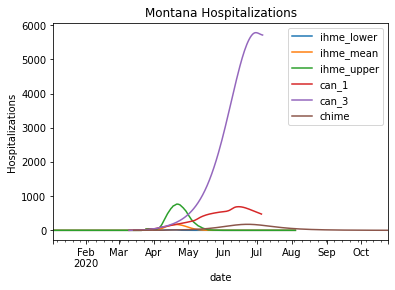

In [160]:
allbed_melt = allbed.copy()
allbed_melt['Date'] = allbed_melt.index
allbed_melt = pd.melt(
    allbed_melt,
    id_vars='Date',
    var_name='Model',
    value_name='Hospitalizations'
)

# alt.Chart(allbed_melt).mark_line().encode(
#         x='Date',
#         y='Hospitalizations',
#         color='Model',
#         tooltip=['Date', 'Hospitalizations']
#     ).interactive()

allbed.plot()
plt.ylabel('Hospitalizations')
plt.title('Montana Hospitalizations')
plt.show()



# Calculate stats

In [166]:
allbed_dop = allbed.idxmax().to_frame()
allbed_max = allbed.max().to_frame()
allbed_stats = allbed_dop.merge(allbed_max, right_index=True, left_index=True)
allbed_stats.columns = ['Day of Peak', 'Peak Value']
allbed_stats

,Day of Peak,Peak Value
ihme_lower,2020-03-30,37.050000
ihme_mean,2020-04-20,171.029073
ihme_upper,2020-04-22,766.243750
can_1,2020-06-15,691.000000
can_3,2020-06-30,5782.730268
chime,2020-06-23,175.486188
